In [2]:
sh=pd.read_csv("C:\\Users\\C KIRANMAYI\\Downloads\\2020Yield\\Phase 1\\csv\\specific_humidity.csv")

In [3]:
sh

,Year,Month,past,pasttopast,specific_humidity
0,1990,1,13.956875,14.266875,13.508125
1,1990,2,12.119375,14.806875,15.061875
2,1990,3,14.160625,16.296875,16.233125
3,1990,4,16.098125,17.394375,16.926250
4,1990,5,16.993125,18.160000,17.631875
...,...,...,...,...,...
355,2019,8,16.568125,18.242500,17.291875
356,2019,9,17.226250,18.771875,18.458125
357,2019,10,18.015625,18.600625,18.680625
358,2019,11,17.374375,18.363750,18.615625


In [4]:
sh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               360 non-null    int64  
 1   Month              360 non-null    int64  
 2   past               360 non-null    float64
 3   pasttopast         360 non-null    float64
 4   specific_humidity  360 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 14.2 KB


In [5]:
#Creating correlation for precipitation
#Creating the correlation matrix for the features
corr_matrix=sh.corr()
corr_matrix

,Year,Month,past,pasttopast,specific_humidity
Year,1.000000e+00,2.844429e-15,0.131708,0.126854,0.115173
Month,2.844429e-15,1.000000e+00,0.470017,0.463592,0.474784
past,1.317085e-01,4.700168e-01,1.000000,0.785915,0.795755
pasttopast,1.268535e-01,4.635924e-01,0.785915,1.000000,0.788413
specific_humidity,1.151728e-01,4.747839e-01,0.795755,0.788413,1.000000


In [6]:
mask = np.zeros_like(corr_matrix, dtype=np.bool_)
mask[np.triu_indices_from(mask)]= True

c:\Users\C KIRANMAYI\anaconda3\envs\myenv\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


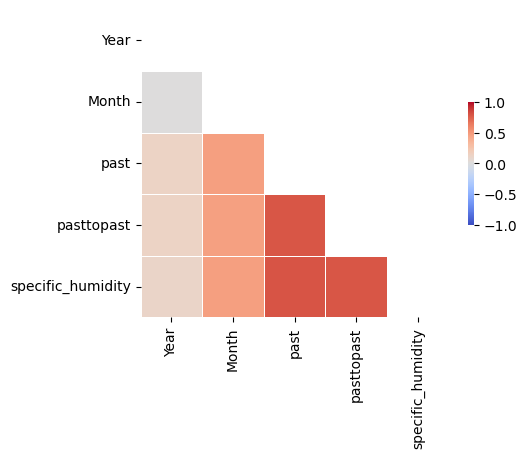

In [7]:
f, ax = plt.subplots(figsize=(5, 4)) 
heatmap = sns.heatmap(corr_matrix, mask = mask,square = True,linewidths = .5, cmap = 'coolwarm', cbar_kws = {'shrink': .4, 'ticks' : [-1, -.5, 0, 0.5, 1]},vmin = -1, vmax = 1,annot = True,annot_kws = {'size': 12})
#add the column names as labels
ax.set_yticklabels(corr_matrix.columns, rotation = 0)
ax.set_xticklabels(corr_matrix.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

In [8]:
sh=sh.drop(['Year','Month'],axis=1)

In [9]:
sh.shape

(360, 3)

In [10]:
X=sh.drop('specific_humidity',axis=1)
y=sh.specific_humidity

In [11]:
X

,past,pasttopast
0,13.956875,14.266875
1,12.119375,14.806875
2,14.160625,16.296875
3,16.098125,17.394375
4,16.993125,18.160000
...,...,...
355,16.568125,18.242500
356,17.226250,18.771875
357,18.015625,18.600625
358,17.374375,18.363750


In [12]:
y

0      13.508125
1      15.061875
2      16.233125
3      16.926250
4      17.631875
         ...    
355    17.291875
356    18.458125
357    18.680625
358    18.615625
359    17.050625
Name: specific_humidity, Length: 360, dtype: float64

In [13]:
X.shape

(360, 2)

In [14]:
y.shape

(360,)

In [15]:
# Scale the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reshaping data for LSTM/GRU/RNN (samples, timesteps, features)
X_scaled = np.reshape(X_scaled, (X_scaled.shape[0], X_scaled.shape[1], 1))

# Splitting into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42)

# GRU

In [16]:
def create_gru_model(units=64):
    model = Sequential()
    model.add(GRU(units=units, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')
    return model

In [17]:
gru_model = KerasRegressor(build_fn=create_gru_model, verbose=0)

C:\Users\C KIRANMAYI\AppData\Local\Temp\ipykernel_27984\2098133132.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  gru_model = KerasRegressor(build_fn=create_gru_model, verbose=0)


In [18]:
# Define the hyperparameter grid
gru_param_grid = {
    'units': [32, 64, 128],
    'batch_size': [16, 32],
    'epochs': [50, 100]
}

In [19]:
gru_grid = GridSearchCV(estimator=gru_model, param_grid=gru_param_grid, cv=3, scoring='neg_mean_squared_error')

In [20]:
gru_grid_result = gru_grid.fit(X_train, y_train)

In [21]:
print(f"Best GRU params: {gru_grid_result.best_params_}")
print(f"Best GRU score: {gru_grid_result.best_score_}")

Best GRU params: {'batch_size': 16, 'epochs': 100, 'units': 128}
Best GRU score: -0.6736759398316562


# LSTM

In [22]:
def create_lstm_model(units=64):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')
    return model

In [23]:
lstm_model = KerasRegressor(build_fn=create_lstm_model, verbose=0)

C:\Users\C KIRANMAYI\AppData\Local\Temp\ipykernel_27984\1916978622.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = KerasRegressor(build_fn=create_lstm_model, verbose=0)


In [24]:
# Define the hyperparameter grid
lstm_param_grid = {
    'units': [32, 64, 128],
    'batch_size': [16, 32],
    'epochs': [50, 100]
}

In [25]:
lstm_grid = GridSearchCV(estimator=lstm_model, param_grid=lstm_param_grid, cv=3, scoring='neg_mean_squared_error')

In [26]:
lstm_grid_result = lstm_grid.fit(X_train, y_train)

In [27]:
print(f"Best LSTM params: {lstm_grid_result.best_params_}")
print(f"Best LSTM score: {lstm_grid_result.best_score_}")

Best LSTM params: {'batch_size': 16, 'epochs': 100, 'units': 128}
Best LSTM score: -0.6714860419126149


# RNN

In [28]:
def create_rnn_model(units=64):
    model = Sequential()
    model.add(SimpleRNN(units=units, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')
    return model

In [29]:
rnn_model = KerasRegressor(build_fn=create_rnn_model, verbose=0)

C:\Users\C KIRANMAYI\AppData\Local\Temp\ipykernel_27984\361697586.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  rnn_model = KerasRegressor(build_fn=create_rnn_model, verbose=0)


In [30]:
rnn_param_grid = {
    'units': [32, 64, 128],
    'batch_size': [16, 32],
    'epochs': [50, 100]
}

In [31]:
rnn_grid = GridSearchCV(estimator=rnn_model, param_grid=rnn_param_grid, cv=3, scoring='neg_mean_squared_error')

In [32]:
rnn_grid_result = rnn_grid.fit(X_train, y_train)

In [33]:

print(f"Best SimpleRNN params: {rnn_grid_result.best_params_}")
print(f"Best SimpleRNN score: {rnn_grid_result.best_score_}")

Best SimpleRNN params: {'batch_size': 16, 'epochs': 100, 'units': 128}
Best SimpleRNN score: -0.7549539018233861


In [34]:
# Evaluating GRU model on test data
best_gru_model = gru_grid_result.best_estimator_
y_pred_gru = best_gru_model.predict(X_test)
mse_gru = mean_squared_error(y_test, y_pred_gru)


print(f"GRU Model - MSE: {mse_gru}")

# Evaluating LSTM model on test data
best_lstm_model = lstm_grid_result.best_estimator_
y_pred_lstm = best_lstm_model.predict(X_test)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)


print(f"LSTM Model - MSE: {mse_lstm}")

# Evaluating SimpleRNN model on test data
best_rnn_model = rnn_grid_result.best_estimator_
y_pred_rnn = best_rnn_model.predict(X_test)
mse_rnn = mean_squared_error(y_test, y_pred_rnn)


print(f"SimpleRNN Model - MSE: {mse_rnn}")


GRU Model - MSE: 0.5227438048729115
LSTM Model - MSE: 0.5265980880986345
SimpleRNN Model - MSE: 0.624997409826667


## LSTM is sutaible for Specific Humdidity with least MSE

In [35]:
sh2021=pd.read_csv("C:\\Users\\C KIRANMAYI\\Downloads\\2020Yield\\Phase 1\\csv\\2020\\specific_humidity.csv")

In [36]:
sh2021=sh2021.drop(['Year','Month'],axis=1)

In [37]:
sh2021

,past,pasttopast
0,13.706875,14.296250
1,15.436250,14.582500
2,15.438125,15.806875
3,17.030625,17.800625
4,18.608125,18.908125
5,17.956250,17.542500
6,17.287500,17.224375
7,17.291875,16.568125
8,18.458125,17.226250
9,18.680625,18.015625


In [38]:
sh2020_pred=[]

In [39]:
sh2021_scaled = scaler.transform(sh2021)

# Reshape for prediction
sh2021_scaled = np.reshape(sh2021_scaled, (sh2021_scaled.shape[0], sh2021_scaled.shape[1], 1))

In [40]:
best_model = gru_grid_result.best_estimator_
sh2020_pred=best_model.predict(sh2021_scaled)

In [41]:
sh2020_pred

array([14.135508, 15.583953, 15.764531, 17.09116 , 18.07859 , 17.593508,
       17.175913, 17.099659, 17.826336, 18.023014, 17.923107, 16.914028],
      dtype=float32)

In [1]:
shum_data=pd.DataFrame(data=sh2020_pred)
shum_data

,0
0,15.135508
1,14.583953
2,15.764531
3,17.091160
4,18.078590
5,17.593508
6,17.175913
7,18.099659
8,17.826336
9,18.023014


In [43]:
shum_data.to_csv("C:\\Users\\C KIRANMAYI\\Downloads\\2020Yield\\Phase 1\\csv\\2020\\specific_humidity1.csv")